# Post hoc analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from log_distance_measures.config import EventLogIDs, AbsoluteTimestampType, DistanceMetric, discretize_to_hour
from log_distance_measures.earth_movers_distance import earth_movers_distance
from log_distance_measures.absolute_event_distribution import _discretize as aed_discretize
from log_distance_measures.relative_event_distribution import _relativize_and_discretize as red_discretize
import datetime
import math

import pandas as pd
from scipy.stats import wasserstein_distance

from log_distance_measures.config import EventLogIDs, DistanceMetric
from log_distance_measures.earth_movers_distance import earth_movers_distance

In [2]:
path_sim_dir = os.path.join('..', 'data', 'simulated_data', 'threats')

## Helper functions

In [3]:
# REDD

# taken and from https://github.com/AutomatedProcessImprovement/log-distance-measures/blob/main/src/log_distance_measures/relative_event_distribution.py



def _relativize_and_discretize(
        event_log: pd.DataFrame,
        log_ids: EventLogIDs,
        discretize_type: AbsoluteTimestampType = AbsoluteTimestampType.BOTH,
        discretize_event=discretize_to_hour  # function to discretize a total amount of seconds into bins
) -> list:
    """
    Transform each timestamp (start, end, or both, depending on [discretize_type]) in the event log by making it relative w.r.t. the start
    time of its trace, and then discretize them using the function [discretize_event] (to absolute hours by default).

    :param event_log: event log.
    :param log_ids: mapping for the column IDs of the event log.
    :param discretize_type: type of EMD measure (only take into account start timestamps, only end timestamps, or both).
    :param discretize_event: function to discretize the total amount of seconds each timestamp represents, default to hour.

    :return: A list with the relative and discretized timestamps of the log.
    """
    # Make relative w.r.t. the start of their case
    relative_starts, relative_ends = [], []
    for case_id, events in event_log.groupby(log_ids.case):
        case_start = events[log_ids.start_time].min()
        if discretize_type != AbsoluteTimestampType.END:
            # Consider either 'start' or both, so add the discretized start times
            relative_starts += [instant - case_start for instant in events[log_ids.start_time]]
        if discretize_type != AbsoluteTimestampType.START:
            # Consider either 'end' or both, so add the discretized end times
            relative_ends += [instant - case_start for instant in events[log_ids.end_time]]
    # Discretize each instant to its corresponding "bin"
    discretized_events = []
    if discretize_type != AbsoluteTimestampType.END:
        # Consider either 'start' or both, so add the discretized start times
        discretized_events += [
            discretize_event(difference.total_seconds()) for difference in relative_starts
        ]
    if discretize_type != AbsoluteTimestampType.START:
        # Consider either 'end' or both, so add the discretized end times
        discretized_events += [
            discretize_event(difference.total_seconds()) for difference in relative_ends
        ]
    # Return discretized timestamps
    return discretized_events

In [4]:
log_ids_sim = EventLogIDs(
    case="case_id",
    activity="activity_name",
    start_time="start_timestamp",
    end_time="end_timestamp",
    resource="resource"
)

In [5]:
# taken and adapted from https://github.com/AutomatedProcessImprovement/log-distance-measures/blob/main/src/log_distance_measures/cycle_time_distribution.py

def cycle_time_distribution(
        original_log: pd.DataFrame,
        original_ids: EventLogIDs,
        simulated_log: pd.DataFrame,
        simulated_ids: EventLogIDs,
        bin_size: datetime.timedelta,
        metric: DistanceMetric = DistanceMetric.WASSERSTEIN,
        normalize: bool = False
) -> float:
    """
    EMD (or Wasserstein Distance) between the distribution of cycle times of two event logs. To get this distribution, the cycle times are
    discretized to bins of size [bin_size].

    :param original_log: first event log.
    :param original_ids: mapping for the column IDs of the first event log.
    :param simulated_log: second event log.
    :param simulated_ids: mapping for the column IDs for the second event log.
    :param bin_size: time interval to define the bin size.
    :param metric: distance metric to use in the histogram comparison.
    :param normalize: whether to normalize the distance metric to a value in [0.0, 1.0].

    :return: the EMD between the cycle time distribution of the two event logs, measuring the amount of movements (considering their
    distance) to transform one cycle time histogram into the other.
    """
    # Get trace durations of each trace for the first log
    original_cycle_times = []
    for case, events in original_log.groupby(original_ids.case):
        original_cycle_times += [events[original_ids.end_time].max() - events[original_ids.start_time].min()]
    # Get trace durations of each trace for the second log
    simulated_cycle_times = []
    for case, events in simulated_log.groupby(simulated_ids.case):
        simulated_cycle_times += [events[simulated_ids.end_time].max() - events[simulated_ids.start_time].min()]
    # Discretize each event to its corresponding "bin"
    min_duration = min(original_cycle_times + simulated_cycle_times)
    original_discrete_ct = [
        math.floor((trace_duration - min_duration) / bin_size)
        for trace_duration in original_cycle_times
    ]
    simulated_discrete_ct = [
        math.floor((trace_duration - min_duration) / bin_size)
        for trace_duration in simulated_cycle_times
    ]
    
    return original_discrete_ct, simulated_discrete_ct

In [6]:
# Function to read a CSV file and apply timestamp conversion
def read_and_convert(file_path):
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file_path)
    
    # Apply conversion to 'start_timestamp' and 'end_timestamp'
    for timestamp in ['start_timestamp', 'end_timestamp']:
        if timestamp in df.columns:
            df[timestamp] = pd.to_datetime(df[timestamp], errors='coerce', format='mixed')
    
    return df

In [7]:
def get_log_length(event_log: pd.DataFrame, start_col: str, end_col: str) -> float:
    """
    Calculates the length of the event log in days by subtracting the earliest start timestamp 
    from the latest end timestamp.

    :param event_log: The DataFrame containing the event log.
    :param start_col: The name of the column with the start timestamps.
    :param end_col: The name of the column with the end timestamps.
    :return: The length of the log in days as a float.
    """
    # Convert to datetime if not already
    event_log[start_col] = pd.to_datetime(event_log[start_col])
    event_log[end_col] = pd.to_datetime(event_log[end_col])

    # Calculate the earliest start and latest end timestamps
    earliest_start = event_log[start_col].min()
    latest_end = event_log[end_col].max()

    # Calculate the difference in days
    log_length_days = (latest_end - earliest_start).days + (latest_end - earliest_start).seconds / 86400

    # Convert days to months
    log_length_months = log_length_days / 30.44  # Average number of days in a month


    return np.round(log_length_months, 2)

In [8]:
def plot_discretized_timestamps(distr_test, distr_sim, distribution=''):

    # Plot the discretized timestamps for both original and simulated logs
    plt.figure(figsize=(10, 6))
    
    # Plot original log discretized events
    plt.hist(distr_test, bins=30, alpha=0.5, label='Original Log', color='blue', edgecolor='black')

    # Plot simulated log discretized events
    plt.hist(distr_sim, bins=30, alpha=0.5, label='Simulated Log', color='orange', edgecolor='black')

    # Labels and title
    plt.xlabel('Discretized Time')
    plt.ylabel('Frequency')
    plt.title(f'{distribution}: Discretized Timestamps Comparison (Original vs Simulated Log)')
    plt.legend(loc='upper right')
    
    # Show the plot
    plt.show()


In [9]:
def get_distribution_plots(data, strategies):
    for strategy in strategies:
        df_sim  = data['sim'][strategy]
        df_test = data['test'][strategy]
        
        print('#####', strategy)
        print('SIM length months:', get_log_length(df_sim, start_col='start_timestamp', end_col='end_timestamp'))
        print('TEST length months:', get_log_length(df_test, start_col='start_timestamp', end_col='end_timestamp'))

        print('Sim events:', len(df_sim))
        print('Test events:', len(df_test))

        print('Sim cases:', df_sim[log_ids_sim.case].nunique())
        print('Test cases:', df_test[log_ids_sim.case].nunique())

        aed_test, aed_sim = aed_discretize(original_log= df_test,
            original_ids= log_ids_sim,
            simulated_log= df_sim, 
            simulated_ids= log_ids_sim,
            # discretize_type= AbsoluteTimestampType
            # discretize_event=discretize_to_hour
            )
        plot_discretized_timestamps(aed_test, aed_sim, distribution='AED')


        red_test = red_discretize(event_log=df_test, log_ids=log_ids_sim)
        red_sim  = red_discretize(event_log=df_sim, log_ids=log_ids_sim)
        plot_discretized_timestamps(red_test, red_sim, distribution='RED')

        lt_test, lt_sim = cycle_time_distribution(original_log= df_test,
            original_ids= log_ids_sim,
            simulated_log= df_sim, 
            simulated_ids= log_ids_sim, 
            bin_size= pd.Timedelta(hours=1))
        
        plot_discretized_timestamps(lt_test, lt_sim, distribution='LTD')

In [10]:
import seaborn as sns

def plot_redd(discretized_events):
    plt.figure(figsize=(10, 6))
    sns.histplot(discretized_events, bins=20, kde=False)
    plt.title("Distribution of Discretized Event Timestamps")
    plt.xlabel("Discretized Time (Hours from Case Start)")
    plt.ylabel("Frequency")
    # plt.ylim(0, 10000)
    plt.grid(True)
    plt.show()

## Analysis per threat


### T1: Concept drift

In [11]:
# reading sample logs in
path_sim_log_pre  = os.path.join(path_sim_dir, 'helpdesk_two_scenarios/helpdesk_h1/main_results/simulated_log_0.csv')
path_sim_log_post = os.path.join(path_sim_dir, 'helpdesk_two_scenarios/helpdesk_h1_2/main_results/simulated_log_0.csv')

path_test_log_pre  = os.path.join(path_sim_dir, 'helpdesk_two_scenarios/helpdesk_h1/main_results/test_preprocessed.csv')
path_test_log_post = os.path.join(path_sim_dir, 'helpdesk_two_scenarios/helpdesk_h1_2/main_results/test_preprocessed.csv')


data_drift = {
    'sim':  {
        'pre_drift':    read_and_convert(path_sim_log_pre),
        'across_drift': read_and_convert(path_sim_log_post)
    },
    'test': {
        'pre_drift':    read_and_convert(path_test_log_pre),
        'across_drift': read_and_convert(path_test_log_post)
    }
}

##### pre_drift
SIM length months: 9.13
TEST length months: 5.78
Sim events: 3550
Test events: 3180
Sim cases: 745
Test cases: 745


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


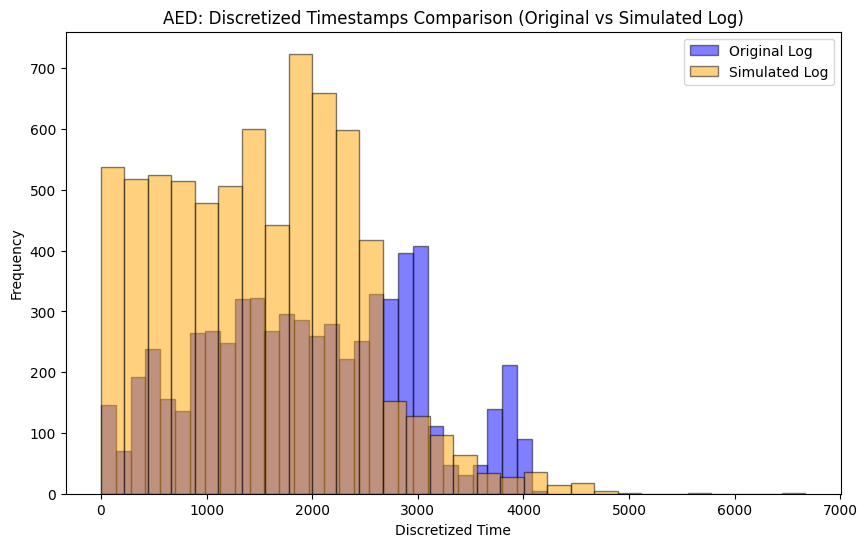

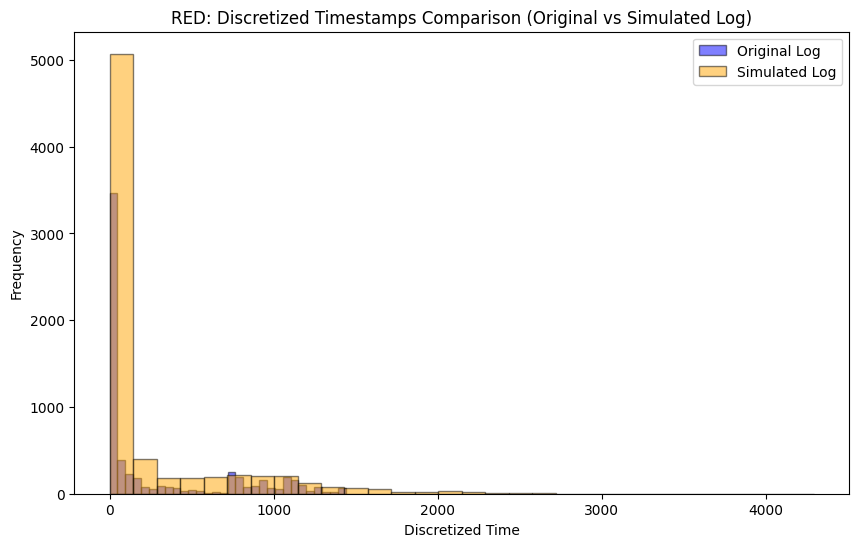

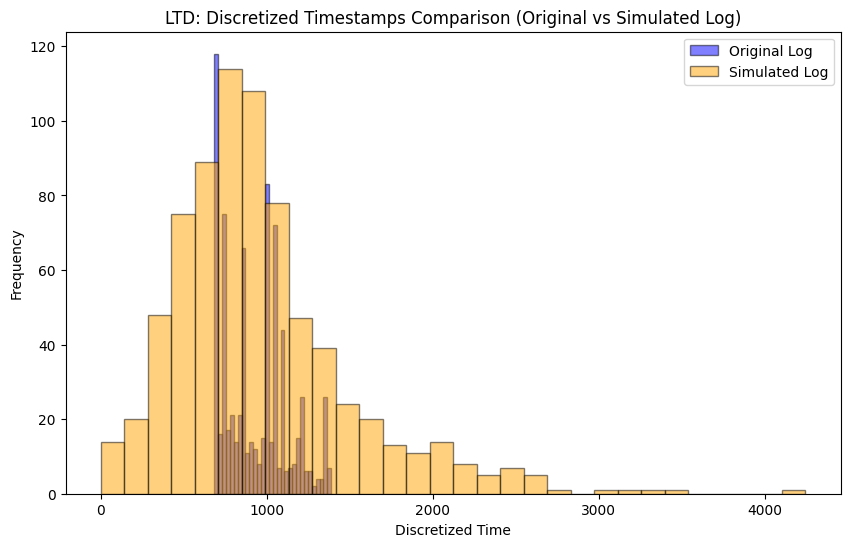

##### across_drift
SIM length months: 8.05
TEST length months: 14.99
Sim events: 3578
Test events: 3563
Sim cases: 744
Test cases: 744


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


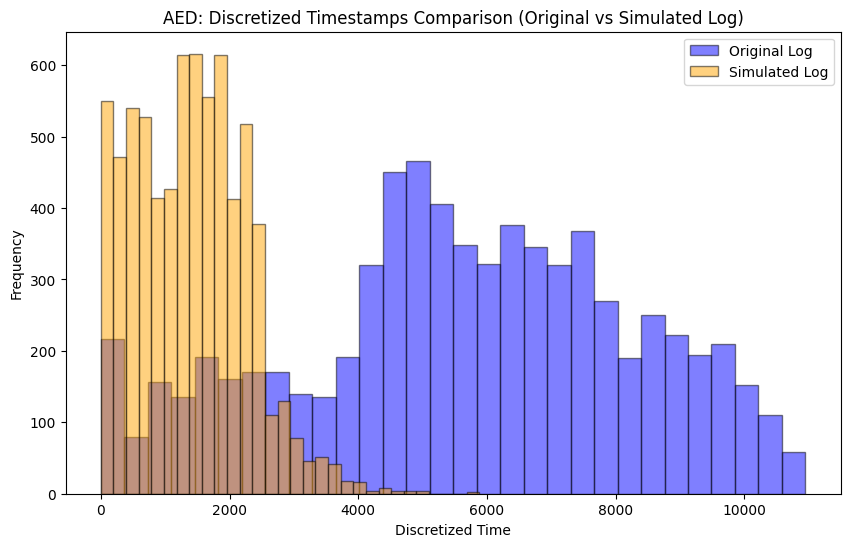

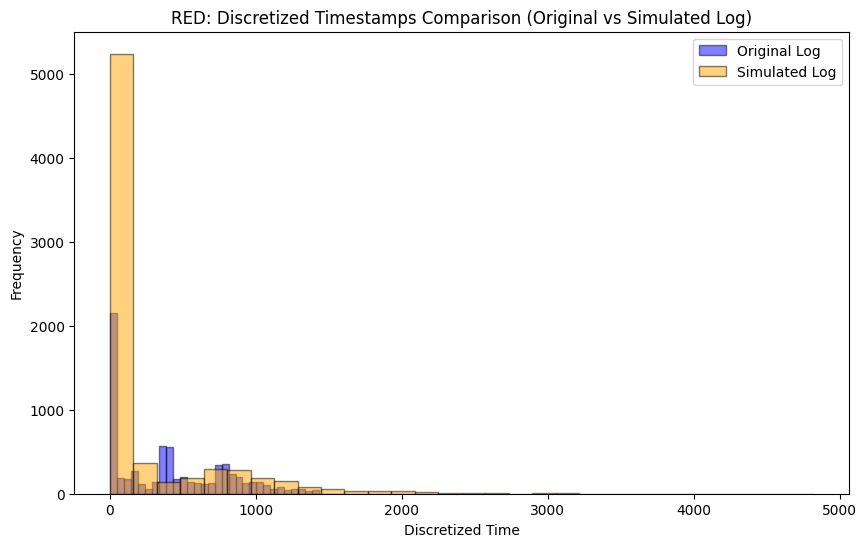

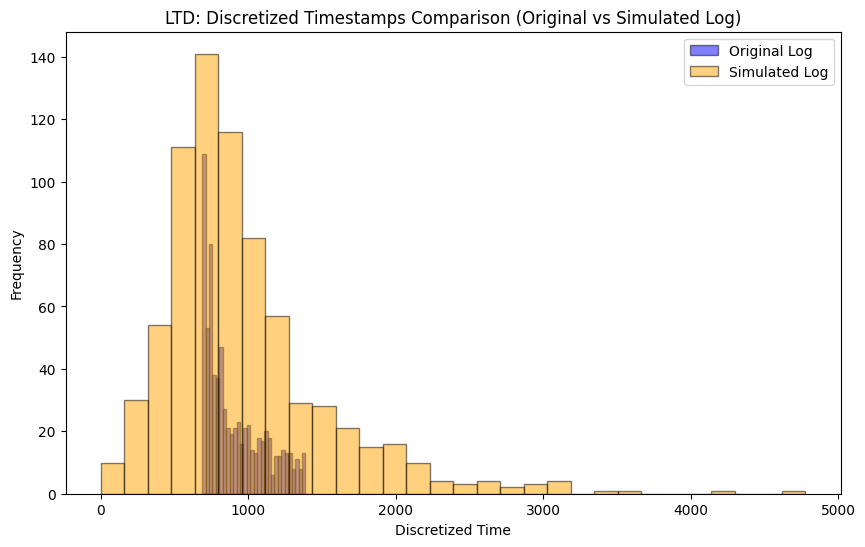

In [12]:
drift_scenarios = ['pre_drift', 'across_drift']

get_distribution_plots(data_drift, drift_scenarios)

### T2: Fading-in and out Phases in Extracted Logs

In [13]:

base_path = os.path.join(path_sim_dir, 't2_3')


# Define the relative paths for the files
sim_path_starting_extension  = 'BPIC_2012_W_starting_intermediate/main_results/simulated_log_0.csv'
sim_path_contained_extension = 'BPIC_2012_W_contained_intermediate/main_results/simulated_log_0.csv'
sim_path_cut_extension       = 'BPIC_2012_W_cut_intermediate/main_results/simulated_log_0.csv'

test_path_starting_extension  = 'BPIC_2012_W_starting_intermediate/main_results/test_preprocessed.csv'
test_path_contained_extension = 'BPIC_2012_W_contained_intermediate/main_results/test_preprocessed.csv'
test_path_cut_extension       = 'BPIC_2012_W_cut_intermediate/main_results/test_preprocessed.csv'

# Join base path with file paths
sim_starting  = os.path.join(base_path, sim_path_starting_extension)
sim_contained = os.path.join(base_path, sim_path_contained_extension)
sim_cut       = os.path.join(base_path, sim_path_cut_extension)

test_path_starting = os.path.join(base_path, test_path_starting_extension)
test_path_contained = os.path.join(base_path, test_path_contained_extension)
test_path_cut = os.path.join(base_path, test_path_cut_extension)


# Dictionary to store the DataFrames
data_extraction = {
    'sim': {
        'starting': read_and_convert(sim_starting),
        'contained': read_and_convert(sim_contained),
        'cut': read_and_convert(sim_cut)
    },
    'test': {
        'starting': read_and_convert(test_path_starting),
        'contained': read_and_convert(test_path_contained),
        'cut': read_and_convert(test_path_cut)
    }
}


##### starting
SIM length months: 2.52
TEST length months: 2.0
Sim events: 5600
Test events: 7090
Sim cases: 1002
Test cases: 1002


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


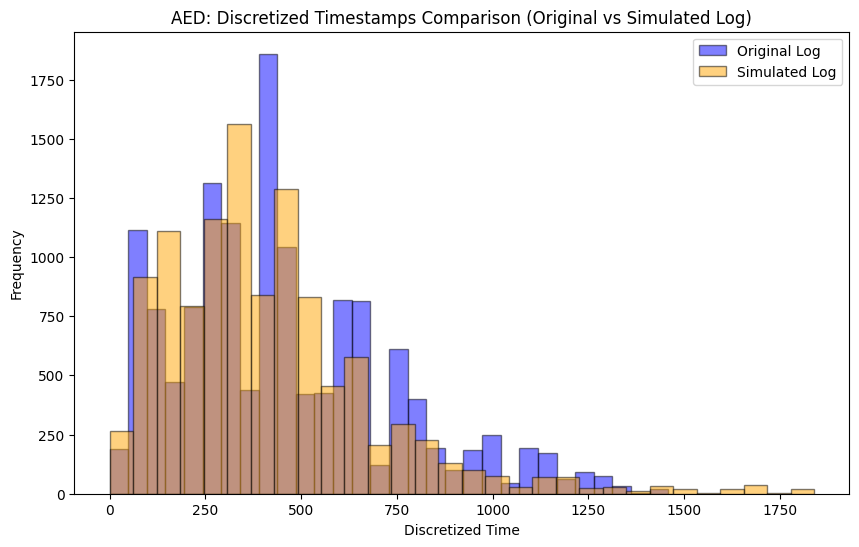

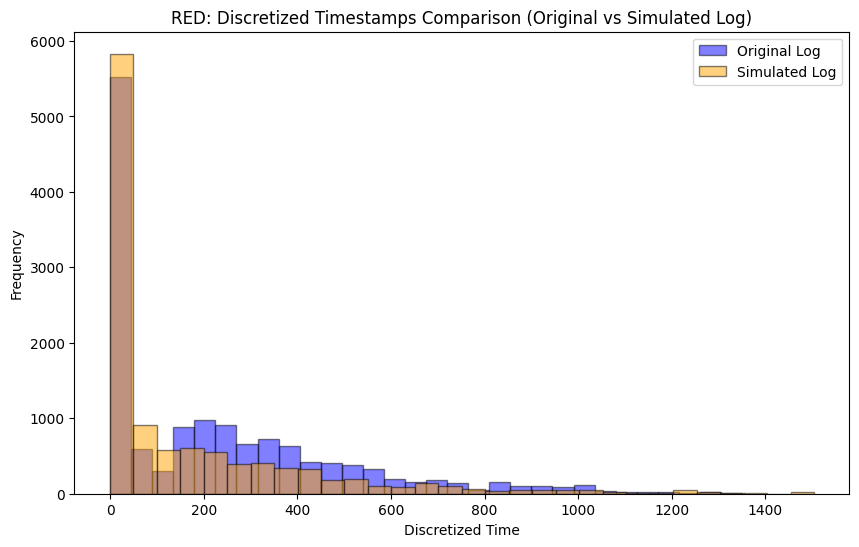

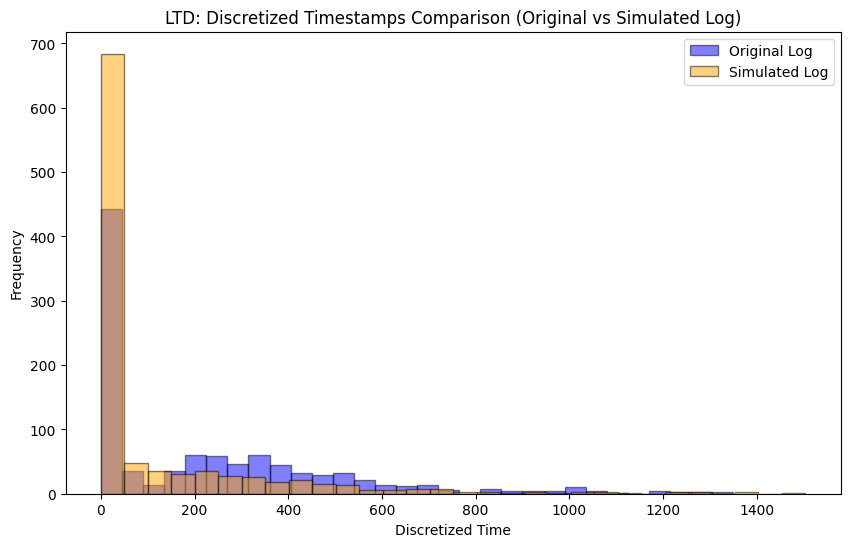

##### contained
SIM length months: 1.81
TEST length months: 0.74
Sim events: 4684
Test events: 3501
Sim cases: 893
Test cases: 893


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


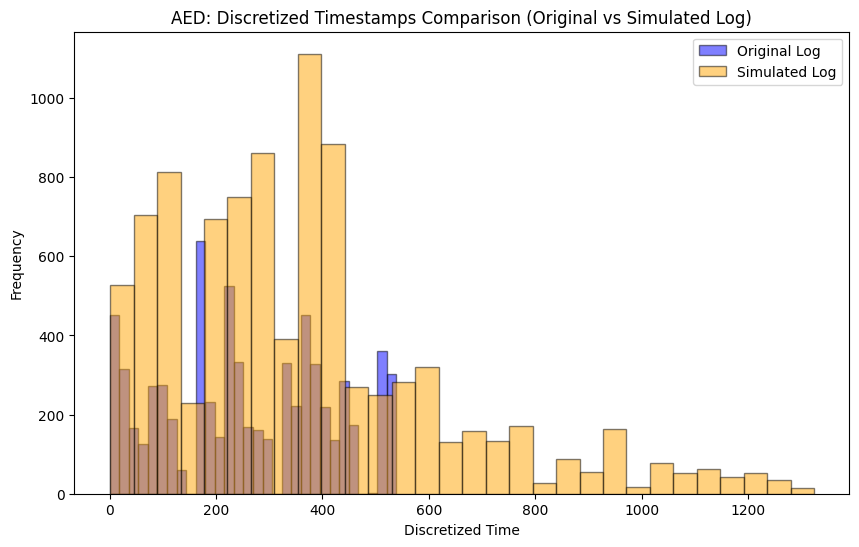

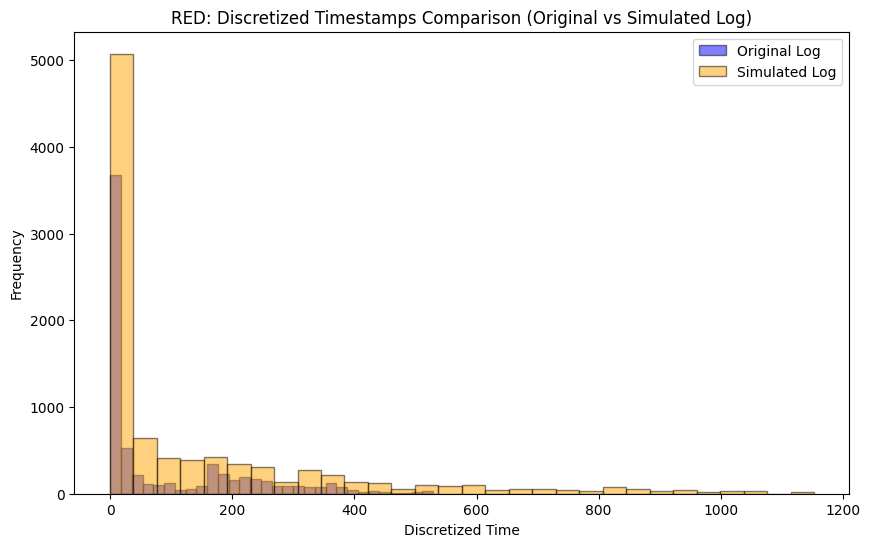

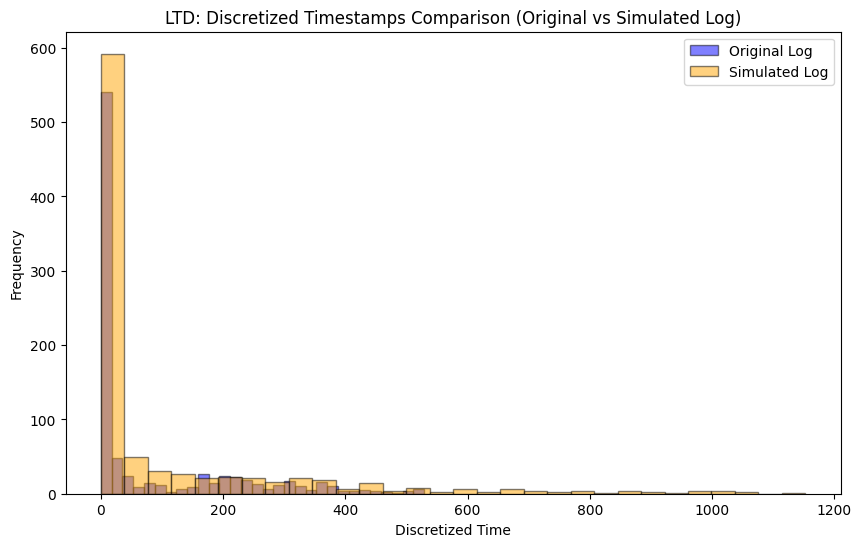

##### cut
SIM length months: 2.56
TEST length months: 0.63
Sim events: 6468
Test events: 4558
Sim cases: 1096
Test cases: 1096


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


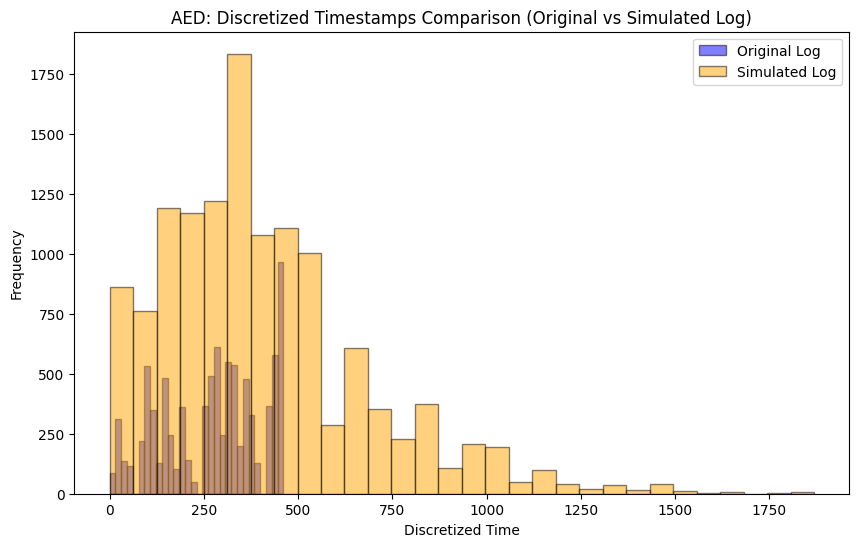

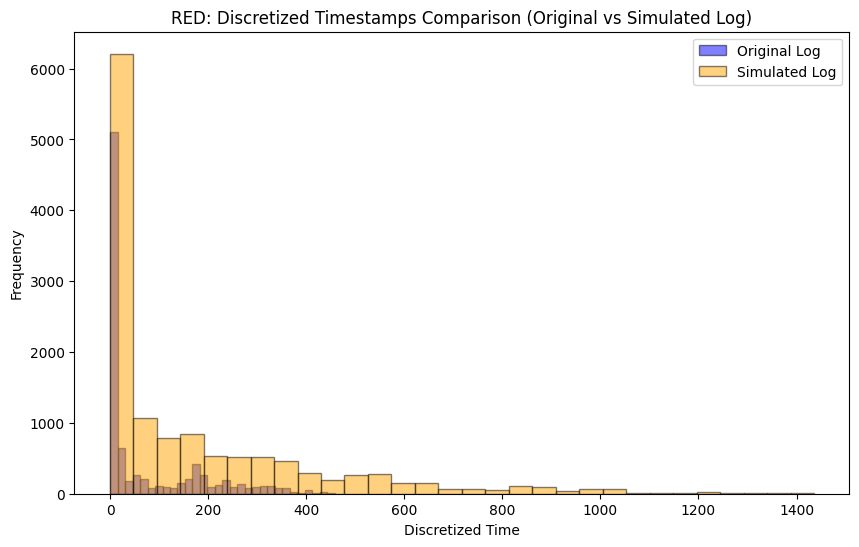

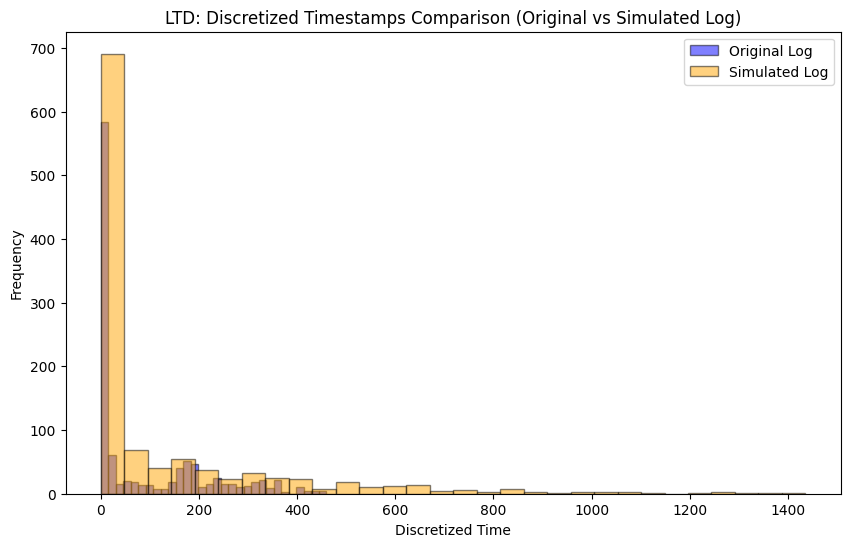

In [14]:
strategies = ['starting', 'contained', 'cut']

get_distribution_plots(data_extraction, strategies)
    

### T3: Fading-out and in Phases around the Splitting Point

In [15]:
base_path = os.path.join(path_sim_dir, 't2_3')

# Define the relative paths for the files
sim_path_regular_extension      = 'BPIC_2012_W_starting_regular/main_results/simulated_log_1.csv'
sim_path_intermediate_extension = 'BPIC_2012_W_starting_intermediate/main_results/simulated_log_1.csv'
sim_path_strict_extension       = 'BPIC_2012_W_starting_strict/main_results/simulated_log_1.csv'

test_path_regular_extension      = 'BPIC_2012_W_starting_regular/main_results/test_preprocessed.csv'
test_path_intermediate_extension = 'BPIC_2012_W_starting_intermediate/main_results/test_preprocessed.csv'
test_path_strict_extension       = 'BPIC_2012_W_starting_strict/main_results/test_preprocessed.csv'

# Join base path with file paths
sim_regular      = os.path.join(base_path, sim_path_regular_extension)
sim_intermediate = os.path.join(base_path, sim_path_intermediate_extension)
sim_strict       = os.path.join(base_path, sim_path_strict_extension)

test_path_regular      = os.path.join(base_path, test_path_regular_extension)
test_path_intermediate = os.path.join(base_path, test_path_intermediate_extension)
test_path_strict       = os.path.join(base_path, test_path_strict_extension)


# Dictionary to store the DataFrames
data_splitting = {
    'sim': {
        'regular': read_and_convert(sim_regular),
        'intermediate': read_and_convert(sim_intermediate),
        'strict': read_and_convert(sim_strict)
    },
    'test': {
        'regular': read_and_convert(test_path_regular),
        'intermediate': read_and_convert(test_path_intermediate),
        'strict': read_and_convert(test_path_strict)
    }
}


##### regular
SIM length months: 2.71
TEST length months: 2.0
Sim events: 6524
Test events: 7090
Sim cases: 1002
Test cases: 1002


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


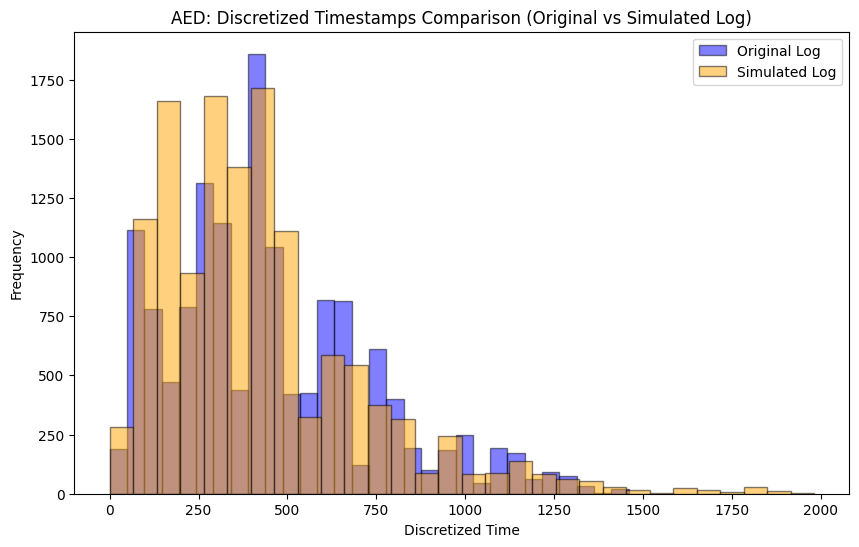

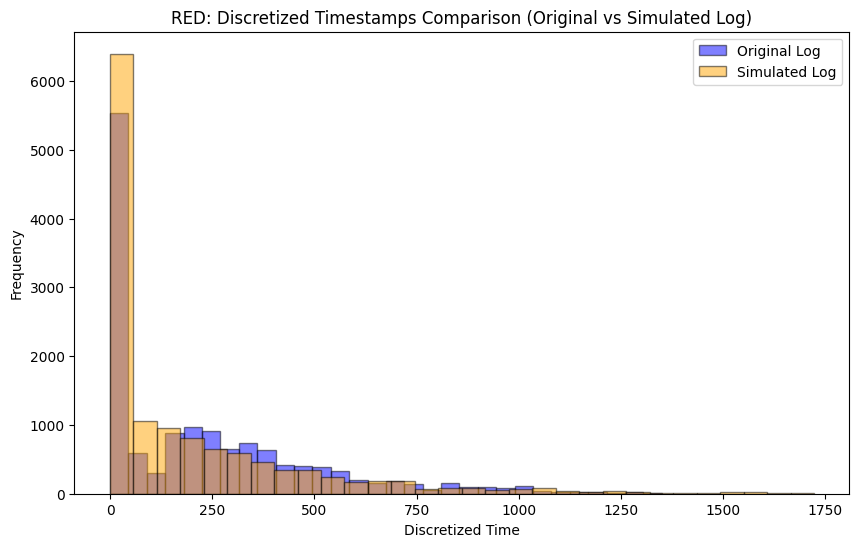

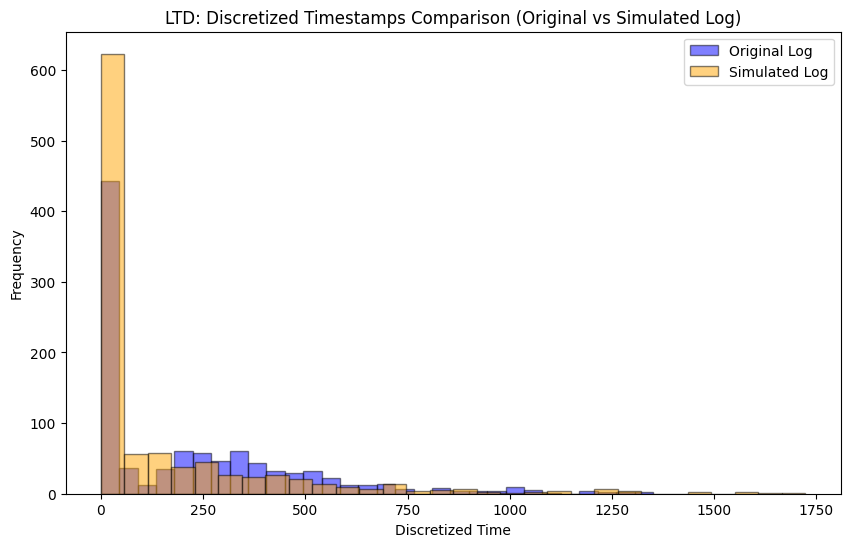

##### intermediate
SIM length months: 2.63
TEST length months: 2.0
Sim events: 5442
Test events: 7090
Sim cases: 1002
Test cases: 1002


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


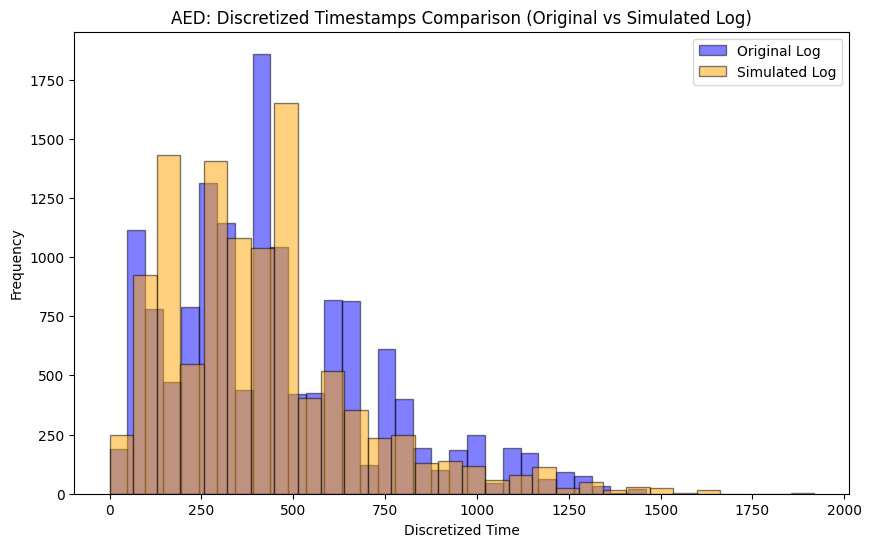

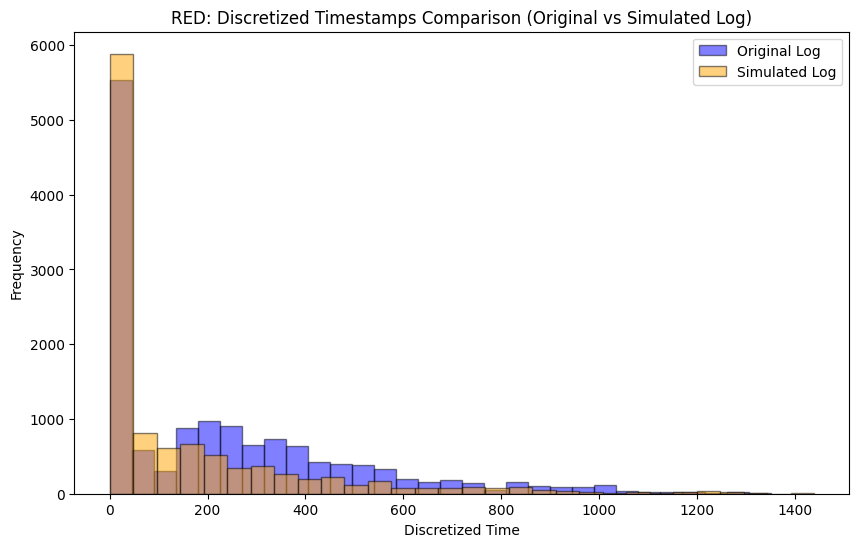

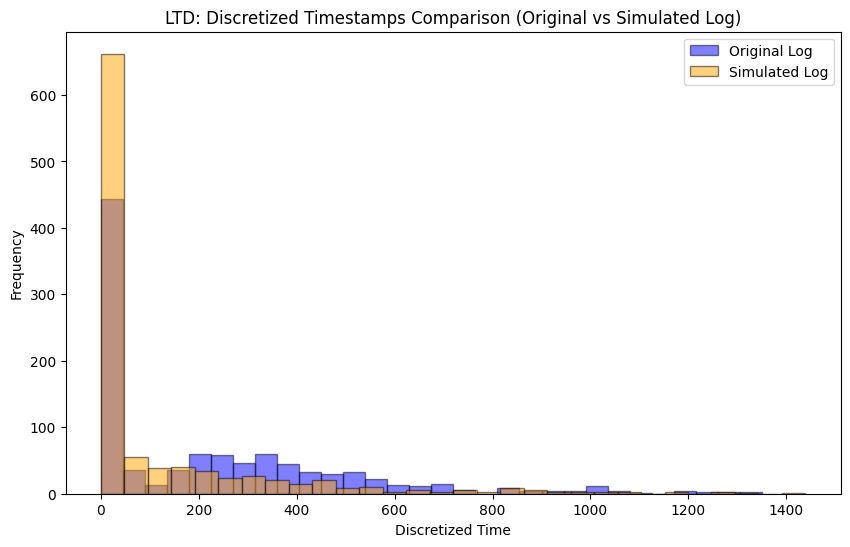

##### strict
SIM length months: 2.89
TEST length months: 2.0
Sim events: 8892
Test events: 11347
Sim cases: 1550
Test cases: 1550


/opt/homebrew/Caskroom/miniconda/base/envs/bps_evaluation/lib/python3.11/site-packages/log_distance_measures/absolute_event_distribution.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).floor(freq='H')


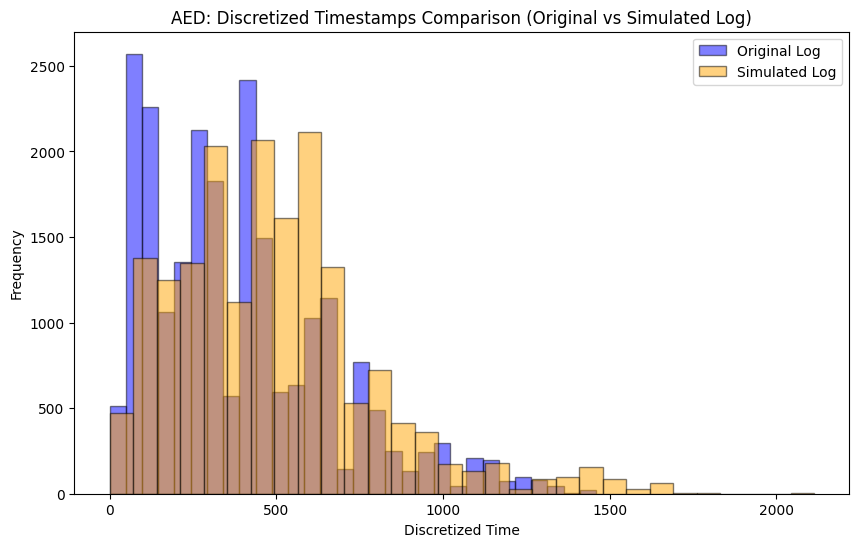

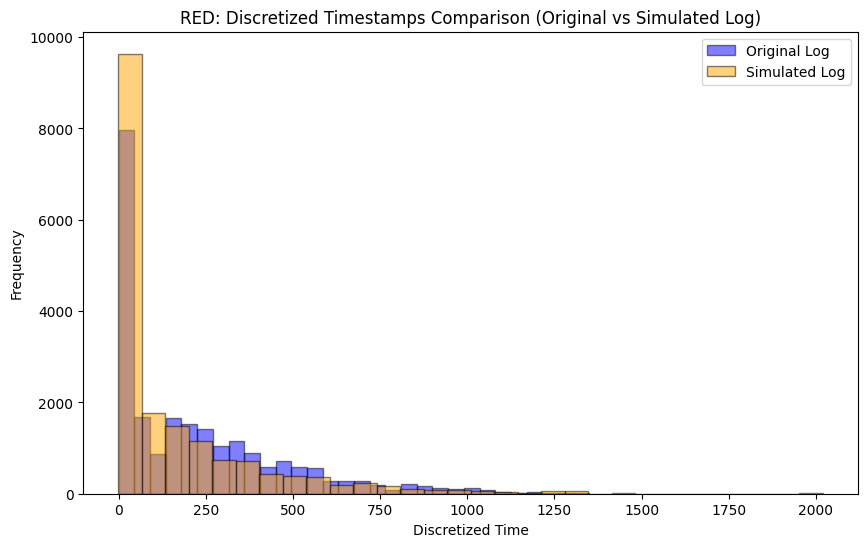

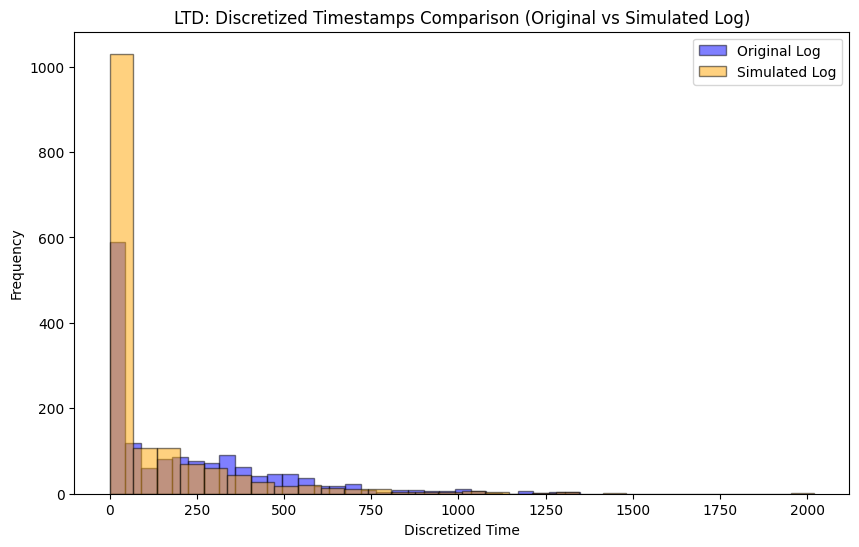

In [16]:
strategies_splitting = ['regular', 'intermediate', 'strict']

get_distribution_plots(data_splitting, strategies_splitting)
    

### T5: Warm-up and Cool-down Phases of Simulated Logs
see t5_warm_up_cool_down.ipynb for a waiting time analysis